In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy

from fuzzywuzzy import fuzz

import networkx
from networkx.algorithms.components.connected import connected_components


from os.path import join
import json

DATA_PATH = 'data'

with open(join(DATA_PATH, 'countries_vocab.json'), 'r', encoding="utf-8") as f:
    countries_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    coun_num = len(set(countries_dict.values()))
    print(f"Number of countries: {coun_num}")
    
with open(join(DATA_PATH, 'occupations_vocab.json'), 'r', encoding="utf-8") as f:
    occupations_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    occ_num = len(set(occupations_dict.values()))
    print(f"Number of occupations: {occ_num}")
df = pd.read_json(join(DATA_PATH, 'union.json'), lines=True)

Number of countries: 180
Number of occupations: 1249


> Lets first preprocess the list of occupations we have. As can be observerd, there are multiple occupations containing similar words: e.g. music critic, food critic, political critic. Here word critic does not represent what exectly a person do, in this regard it may be a good idea to see, which words are the most frequent in the occupation titles, and drop them if necessary

In [2]:
occupations = [word.split() for word in occupations_dict.values()]

In [3]:
from collections import Counter
Counter(sum(occupations, [])).most_common()[:15]

[('player', 50),
 ('artist', 38),
 ('designer', 22),
 ('manager', 22),
 ('coach', 22),
 ('director', 21),
 ('of', 18),
 ('engineer', 17),
 ('game', 15),
 ('video', 14),
 ('writer', 14),
 ('scientist', 13),
 ('officer', 13),
 ('actor', 13),
 ('historian', 13)]

> We will join all the profession containing `artists`, `player`, `video game`. Moreover we will replace `chief executive officer` with `executive director` to distingfish them from `police officer`

In [4]:
sport_words = [
    "sport", "archer", "player", 'football', 
    "cricket", "rugby", 'basketball', "biathlon", 
    "hockey", "fitness", "gymnastics", "baseball",
    "wrestling", "curling", "handball", "bobsledder",
    "badminton", "athlete", "runner",
]

for k, v in occupations_dict.items():
    for sport_word in sport_words:
        if sport_word in v:
            occupations_dict[k] = "sport"
    if "game" in v:
        occupations_dict[k] = "video game"
    elif "artist" in v:
        occupations_dict[k] = "artist"
    elif "actor" in v:
        occupations_dict[k] = "actor"
    elif "chief executive officer" in v:
        occupations_dict[k] = "executive director"
    elif "chief creative officer" in v:
        occupations_dict[k] = "creative director"
    elif "chief technology officer" in v:
        occupations_dict[k] = "technology director"
    elif "chief operating officer" in v:
        occupations_dict[k] = "operating director"
            

In [5]:
df.head()

,q,d,id,s,o,gender,birth,occupation_ids,citizenship_id
0,will be playing a lot of the tracks from micro...,2008-12-02 17:59:33,[Q2359518],lockett pundt,1,[male],[+1982-10-07T00:00:00Z],[[Q855091]],[Q30]
1,the corporation looks a bit concerned there te...,2008-10-16 01:39:41,[Q52607733],tessa martin,2,[female],[None],[[Q2500638]],[None]
2,the broker who supposed a large shareholder ha...,2008-12-01 10:39:05,"[Q16148910, Q19938265, Q313918, Q4771995, Q477...",anthony anderson,1,"[male, male, male, male, male]","[+1901-00-00T00:00:00Z, +1981-11-12T00:00:00Z,...","[[Q3282637], [Q3665646], [Q245068, Q10800557, ...","[None, Q30, Q30, Q30, Q145]"
3,whining and bitching and am a sore loser,2008-11-05 07:41:00,[Q76],barack obama,2,[male],[+1961-08-04T00:00:00Z],"[[Q82955, Q40348, Q15958642, Q28532974, Q37243...",[Q30]
4,everybody is a bit concerned with the economy ...,2008-10-17 01:25:29,[Q17180637],jake hansen,3,[male],[+1989-08-21T00:00:00Z],[[Q11774891]],[Q30]


> Then firstly filter occupations, which occured only single time in the dataset 

In [6]:
occ_freq = defaultdict(int)
for occ_ids in df["occupation_ids"].values:
    if occ_ids is not None:
        for occs in occ_ids:
            if occs is not None:
                for o in occs:
                    occ_freq[o] += 1

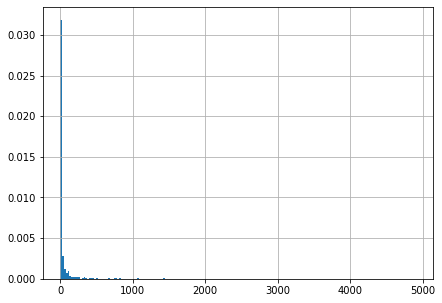

In [7]:
plt.figure(figsize=(7,5))
plt.hist(list(occ_freq.values()), bins=200, density=True)
plt.grid()
plt.show()

In [8]:
def filter_occs(x):
    ids = defaultdict(list)
    for i, occ_ids in enumerate(x["occupation_ids"]):
        ids[i] = []
        if occ_ids is not None:
            for j, occs in enumerate(occ_ids):
                if (occs is not None) and (occ_freq[occs] > 1):
                    ids[i].append(j)
    for i, elem in ids.items():
        if elem:
            x["occupation_ids"][i] = [e for j, e in enumerate(x["occupation_ids"][i]) if j in elem]
    return x
    
    

In [9]:
df = df.apply(lambda x: filter_occs(x), axis=1)

occ_set = set()
for occ_lsts in df["occupation_ids"].values:
    if occ_lsts is not None:
        for lst in occ_lsts:
            if lst is not None:
                occ_set.update(lst)
print(f"Reduced number of occupations: {len(occ_set)}")

Reduced number of occupations: 1024


> First we will filter persons, which occured only single time. For instance, suppose we have a person called `Antonio`, and he has only single quoate in the dataset, which was mentioned in a 

In [10]:
# df["num_qids"] = df["id"].apply(lambda x: len(x))

# multi_qids = df.loc[df["num_qids"] > 1, "id"].values
# rare = set(l[0] for l in df.loc[df["num_qids"] == 1, "id"].values)

# multi = set()
# for l in multi_qids:
#     multi.update(l)
    
# s2occ = defaultdict(int)
# for s_ in rare:
#     s2occ[s_] += 1000 

# for l in multi_qids:
#     for s_ in multi:
#         if s_ in l:
#             s2occ[s_] += 1

# copy_ = deepcopy(s2occ)
# i = 0
# for k, v in copy_.items():
#     if v == 1:
#         del s2occ[k]

In [11]:
# def filter_quids(x):
#     ids = []
#     for i, q in enumerate(x["id"]):
#         if q in s2occ:
#             ids.append(i)
#     if ids:
#         if (len(ids) != len(x["id"])):
#             x["id"] = [e for i, e in enumerate(x["id"]) if i in ids]
#             x["occupation_ids"] = [e for i, e in enumerate(x["occupation_ids"]) if i in ids]
#             x["citizenship_id"] = [e for i, e in enumerate(x["citizenship_id"]) if i in ids]
#             x["birth"] = [e for i, e in enumerate(x["birth"]) if i in ids]
#             x["gender"] = [e for i, e in enumerate(x["gender"]) if i in ids]
#         return x
#     return False
    
    

In [12]:
# df = df.apply(lambda x: filter_quids(x), axis=1)
# df = df[df["id"] != False]
# df.reset_index(drop=True, inplace=True)
# del df["num_qids"]

In [13]:
def change_occupancy_ids_to_names(values: list, dicitonary: dict) -> list:
    """
    :param: values - list of lists of ids
    :param: dicitonary - dictionary for id - name matching
    
    return list strings with union of all possible occupancies for a person
    """
    ans = []
    for quote_array in values:
        person_values = []
        for wikipage_array in quote_array:
            values_ = []
            if wikipage_array is None or len(wikipage_array) == 0:
                values_.append("None")
            else:
                for value_id in wikipage_array:
                    values_.append(dicitonary[value_id])
            person_values.append(values_)
        ans.append(person_values)
        
    return ans

In [14]:
df['occupations'] = change_occupancy_ids_to_names(df.occupation_ids, occupations_dict)
df['citizenship'] = df['citizenship_id'].apply(lambda x: list(None if not c else countries_dict[c] for c in x))

In [15]:
def select_first_from_list(values, depth=1) -> list:
    temp_values = list('None' if v == [] else v[0] for v in values)
            
    if depth == 1:
        return temp_values
    else:
        return select_first_from_list(temp_values, depth=depth-1)

In [16]:
df['citizenship_first'] = select_first_from_list(values=df['citizenship'])
df['occupation_first'] = select_first_from_list(values=df['occupations'], depth=2)
df['gender_first'] = select_first_from_list(values=df['gender'])
df['birth_first'] = select_first_from_list(values=df['birth'])

In [17]:
df['year'] = df['d'].apply(lambda x: x[:4])
df['month'] = df['d'].apply(lambda x: x[5:7])

In [18]:
df.head()

,q,d,id,s,o,gender,birth,occupation_ids,citizenship_id,occupations,citizenship,citizenship_first,occupation_first,gender_first,birth_first,year,month
0,will be playing a lot of the tracks from micro...,2008-12-02 17:59:33,[Q2359518],lockett pundt,1,[male],[+1982-10-07T00:00:00Z],[[Q855091]],[Q30],[[guitarist]],[united states of america],united states of america,guitarist,male,+1982-10-07T00:00:00Z,2008,12
1,the corporation looks a bit concerned there te...,2008-10-16 01:39:41,[Q52607733],tessa martin,2,[female],[None],[[Q2500638]],[None],[[creator]],[None],None,creator,female,None,2008,10
2,the broker who supposed a large shareholder ha...,2008-12-01 10:39:05,"[Q16148910, Q19938265, Q313918, Q4771995, Q477...",anthony anderson,1,"[male, male, male, male, male]","[+1901-00-00T00:00:00Z, +1981-11-12T00:00:00Z,...","[[Q3282637], [Q3665646], [Q245068, Q10800557, ...","[None, Q30, Q30, Q30, Q145]","[[film producer], [sport], [comedian, actor, a...","[None, united states of america, united states...",None,film producer,male,+1901-00-00T00:00:00Z,2008,12
3,whining and bitching and am a sore loser,2008-11-05 07:41:00,[Q76],barack obama,2,[male],[+1961-08-04T00:00:00Z],"[[Q82955, Q40348, Q15958642, Q28532974, Q37243...",[Q30],"[[politician, lawyer, political writer, commun...",[united states of america],united states of america,politician,male,+1961-08-04T00:00:00Z,2008,11
4,everybody is a bit concerned with the economy ...,2008-10-17 01:25:29,[Q17180637],jake hansen,3,[male],[+1989-08-21T00:00:00Z],[[Q11774891]],[Q30],[[sport]],[united states of america],united states of america,sport,male,+1989-08-21T00:00:00Z,2008,10


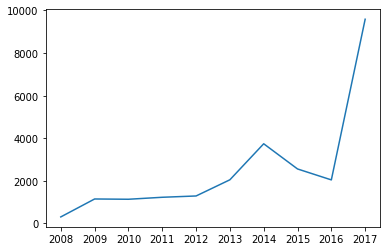

In [19]:
plt.plot(df.groupby('year')['q'].count())
plt.show()

In [20]:
df.groupby(['month', 'year'])['q'].count()

month  year
01     2009      59
       2010     105
       2011     121
       2012      86
       2013      90
               ... 
12     2013     340
       2014     224
       2015     336
       2016     332
       2017    2253
Name: q, Length: 112, dtype: int64

---

#### We can see 2 noticeable peaks, in 2014 and 2017. We want to understand the following things

- who (by occupation) was talking about the ctyptocurrencies/bitcoins/etc throughout the years
- first thing we want to understand is: why peaks are exactly in those years. What happened there that made such a peak 

In [21]:
df.groupby(['year', 'occupation_first'])['q'].count().sort_values(ascending=False)

year  occupation_first   
2017  sport                  2003
2014  sport                   754
2017  politician              740
2015  sport                   646
2017  None                    553
                             ... 
2014  sculptor                  1
2010  technology director       1
2014  ski jumper                1
2010  surfer                    1
2008  N                         1
Name: q, Length: 1852, dtype: int64

In [22]:
df.groupby(['year', 's'])['q'].count().sort_values(ascending=False)

year  s               
2017  Jamie Dimon         140
      Charlie Lee         129
      Tom Lee              86
      Vitalik Buterin      79
2014  Tony Gallippi        77
                         ... 
2013  Blake Skjellerup      1
      Bob Brady             1
      Bob Kelly             1
      Bob McPhail           1
2017  official page         1
Name: q, Length: 12744, dtype: int64

#### Now we need to find same names and occupancies (...)

In [23]:
n = len(occ_set)
occ_lst = list(occ_set)
dist = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        dist[i, j] = fuzz.partial_ratio(occupations_dict[occ_lst[i]], occupations_dict[occ_lst[j]]) > 90

In [24]:
G = networkx.convert_matrix.from_numpy_matrix(dist)

cliques = list(networkx.find_cliques(G))
cliques_text = list(list(map(lambda x: occupations_dict[occ_lst[x]], c)) for c in cliques)

In [25]:
for l in cliques_text:
    if 20 >=len(l) > 1:
        print(l)

['economic historian', 'historian']
['fashion photographer', 'photographer']
['exhibition curator', 'curator']
['television presenter', 'presenter']
['water skier', 'skier']
['medical writer', 'writer']
['geophysicist', 'physicist']
['nuclear physicist', 'physicist']
['human rights activist', 'activist']
['electrical engineer', 'engineer']
['art historian', 'historian', 'military historian']
['art historian', 'historian', 'literary historian']
['historian of science', 'historian']
['consultant', 'computer security consultant', 'security consultant']
['consultant', 'business consultant']
['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor']
['video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game', 'video game']
['anti-vaccine activist', 'activist']
['type designer', 'designer']
['assistant director', 'assistant']
['assistan

In [26]:
# https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also implies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current

In [27]:
G = to_graph(cliques)
simmilar_occupasions = list(connected_components(G))
SIMILAR_OCCUPATIONS_DICT = {i: list(map(lambda x: occupations_dict[occ_lst[x]], c)) for i,c in enumerate(simmilar_occupasions)}

In [28]:
def find_occupation_group(occupation):
    for i, group_occupations in SIMILAR_OCCUPATIONS_DICT.items():
        if occupation in group_occupations:
            return i

In [29]:
df['occupation_first_group'] = df['occupation_first'].apply(lambda x: find_occupation_group(x))

In [30]:
len(df['occupation_first'].unique()), len(df['occupation_first_group'].unique())

(525, 377)

---

##### Now we can group by occupation category

In [31]:
df.groupby('occupation_first_group')['q'].count().sort_values(ascending=False).head(7)

occupation_first_group
10.0     5604
337.0    1972
27.0     1351
7.0      1339
461.0     965
39.0      916
339.0     891
Name: q, dtype: int64

In [32]:
SIMILAR_OCCUPATIONS_DICT[132], SIMILAR_OCCUPATIONS_DICT[200]

(['hedge fund',
  'campaign manager',
  'team manager',
  'bank manager',
  'theatre manager',
  'manager',
  'fund manager',
  'general manager',
  'manager',
  'hotel manager',
  'general manager',
  'manager',
  'hedge fund manager',
  'talent manager'],
 ['film critic',
  'literary critic',
  'comics critic',
  'media critic',
  'food critic',
  'music critic',
  'critic'])

---

In [33]:
a = df.groupby(['year'], as_index=False)

In [34]:
for group in a.groups:
    print('----', group, '----')
    print(a.get_group(group).groupby('occupation_first_group').count().nlargest(5, 'q')['q'])

---- 2008 ----
occupation_first_group
10.0     73
337.0    42
7.0      27
27.0     20
39.0     12
Name: q, dtype: int64
---- 2009 ----
occupation_first_group
10.0     290
337.0    140
7.0       97
27.0      91
39.0      29
Name: q, dtype: int64
---- 2010 ----
occupation_first_group
10.0     327
337.0    133
7.0       77
27.0      60
105.0     26
Name: q, dtype: int64
---- 2011 ----
occupation_first_group
10.0     332
27.0     155
337.0    126
7.0       76
39.0      26
Name: q, dtype: int64
---- 2012 ----
occupation_first_group
10.0     314
337.0    135
7.0       83
27.0      81
134.0     44
Name: q, dtype: int64
---- 2013 ----
occupation_first_group
10.0     434
339.0    123
7.0      120
337.0    112
27.0     110
Name: q, dtype: int64
---- 2014 ----
occupation_first_group
10.0     754
337.0    234
461.0    228
7.0      199
27.0     180
Name: q, dtype: int64
---- 2015 ----
occupation_first_group
10.0     646
337.0    164
27.0     120
7.0      116
105.0    115
Name: q, dtype: int64
---- 